# Hands-on of VQE and QAOA

Takashi Imamichi (IBM Research - Tokyo)

June 11, 2021

In [1]:
# I recommend to install the following packages to run this notebook, but, you can skip this.
# %pip cplex
# %pip uninstall qiskit-optimization
# %pip install https://github.com/Qiskit/qiskit-optimization/archive/stable/0.1.zip

In [6]:
import itertools
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt 
#%matplotlib inline

import qiskit
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import I, X, Y, Z, PauliSumOp
from qiskit.algorithms import VQE, QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer

Make sure that qiskit-terra 0.17.4 and qiskit-aer 0.8.2 are installed if you run it in your local environment.

In [7]:
print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.17.3', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.0', 'qiskit-nature': '0.1.3', 'qiskit-finance': None, 'qiskit-optimization': '0.1.0', 'qiskit-machine-learning': None}


## Generate a graph and solve Maxcut naively

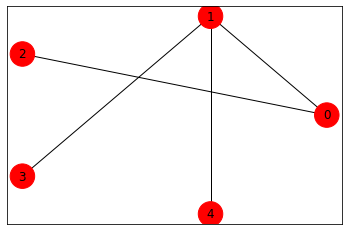

In [83]:
# Generating a graph with 5 nodes 
n = 5
V = np.arange(0,n,1)
E = [(0,1,1), (0,2,1), (1,3,1), (1,4,1)]

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.circular_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [17]:
G[0][1]

{'weight': 1}

In [18]:
# Compute the value of the cost function
def cost_function(x,G):
    if isinstance(x, str):
        x = [int(e) for e in reversed(x)]  # notice that the endianess of qiskit (right to left)

    E = G.edges()
    if(len(x) != len(G.nodes())):
        return np.nan
        
    C = 0
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w = G[e1][e2]['weight']
        C += w*x[e1]*(1-x[e2]) + w*(1-x[e1])*x[e2]

    return C

In [20]:
[int(e) for e in reversed([1,0,0,0,0])]

[0, 0, 0, 0, 1]

cost 2


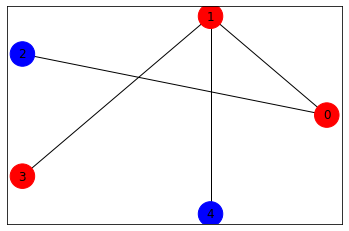

In [24]:
def draw_sol(G, x, pos=None):
    if isinstance(x, str):
        x = [int(e) for e in reversed(x)]  # notice that the endianess of qiskit (right to left)
    print('cost', cost_function(x, G))
    cmap = ['r', 'b']
    colors = [cmap[x[node]] for node in G.nodes()]
    default_axes = plt.axes(frameon=True)
    if pos is None:
        pos = nx.circular_layout(G)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

draw_sol(G, [0,0,1,0,1], pos)

In [28]:
def naive_opt(G):
    n = len(G.nodes())
    best = 0
    sol = []
    for x in itertools.product([0,1], repeat=n):
        val = cost_function(x, G)
        if best < val:
            best = val
            sol = [x]
        elif best == val:
            sol.append(x)
    return best, sol
best, x = naive_opt(G)
print(best, x)

4 [(0, 1, 1, 0, 0), (1, 0, 0, 1, 1)]


cost 4


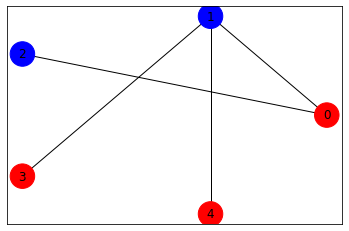

In [8]:
draw_sol(G, x[0], pos)

## Solve Maxcut with Qiskit Terra

In [29]:
# Check endianness

# Opflow operators use xor operator `^` as tensor product
op = Z^Z
print(op.to_matrix())

seed = 1234
maxiter = 200
algorithm_globals.random_seed = seed
ins = QuantumInstance(backend=Aer.get_backend('aer_simulator'), shots=2000, seed_simulator=seed, seed_transpiler=seed)
vqe = VQE(optimizer=COBYLA(maxiter=maxiter), quantum_instance=ins)
result = vqe.compute_minimum_eigenvalue(op)
print(result)
print()
for bit, sqrt_prob in sorted(result.eigenstate.items()):
    print(f'bit {bit}, prob {sqrt_prob ** 2}')
# Z corresponds to the left bit and I corresponds to the right bit.
# Recall that bitstring has the order q[n-1], q[n-2],..., q[1], q[0].

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 69,
    'eigenstate': {'01': 0.7496665925596525, '10': 0.6618156843109719},
    'eigenvalue': -1.0,
    'optimal_parameters': {   ParameterVectorElement(θ[3]): -1.475922887484973,
                              ParameterVectorElement(θ[1]): 0.24636469646884712,
                              ParameterVectorElement(θ[7]): -1.1977633368023402,
                              ParameterVectorElement(θ[0]): 2.9639163979340015,
                              ParameterVectorElement(θ[6]): -1.7391279913638302,
                              ParameterVectorElement(θ[2]): 2.642810418502113,
                              ParameterVectorElement(θ[5]): -1.3937355927839192,
                              ParameterVectorElement(θ[4]): -1.016329520944952},
    'optimal_point': array([ 2.9639164 ,  0.246364

In [30]:
def hamiltonian(G):
    n = len(G.nodes())
    H = 0
    offset = 0
    for i, j in G.edges():
        pauli = ['I'] * n
        pauli[n - i - 1] = pauli[n - j - 1] = 'Z'
        H += PauliSumOp.from_list([(''.join(pauli), 0.5)])
        offset -= 0.5
    return H, offset

H, offset = hamiltonian(G)
print(H)  # ZZ are placed for the edges
print(offset)

0.5 * IIIZZ
+ 0.5 * IIZIZ
+ 0.5 * IZIZI
+ 0.5 * ZIIZI
-2.0


minimum eigenvalue of H: -2.0
the optimal function value: 4.0
[6] [1.+0.j]
{0: '0', 1: '1', 2: '1', 3: '0', 4: '0'}
cost 4


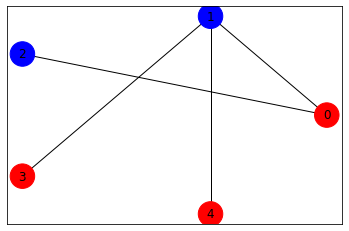

In [35]:
# matrix calculation
eigval, eigvec = np.linalg.eigh(H.to_matrix())
print('minimum eigenvalue of H:', eigval[0])
print('the optimal function value:', -(eigval[0] + offset))
nonzero = np.where(eigvec[:, 0] != 0)[0]
print(nonzero, eigvec[nonzero, 0])
sol = f'{nonzero[0]:05b}'
print(dict(enumerate(sol[::-1])))
draw_sol(G, sol, pos)

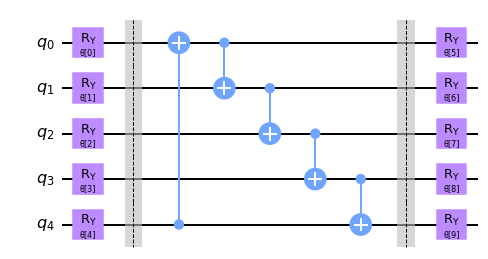

In [32]:
# Example of simple variational form
ansatz = TwoLocal(H.num_qubits, ['ry'], 'cx', entanglement='circular', reps=1, insert_barriers=True)
ansatz.draw(output='mpl')

In [13]:
algorithm_globals.random_seed=seed
ins = QuantumInstance(backend=Aer.get_backend('aer_simulator'), seed_simulator=seed, seed_transpiler=seed)
vqe = VQE(optimizer=COBYLA(maxiter=maxiter), quantum_instance=ins, ansatz=ansatz)
result = vqe.compute_minimum_eigenvalue(H)
print(result)
print('ground state energy', result.optimal_value)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 112,
    'eigenstate': {   '01001': 0.09375,
                      '10001': 0.05412658773652741,
                      '11001': 0.9906792177592099,
                      '11101': 0.08267972847076846},
    'eigenvalue': -1.9814453125,
    'optimal_parameters': {   ParameterVectorElement(θ[1]): -1.5913307861117332,
                              ParameterVectorElement(θ[0]): 4.721598034508926,
                              ParameterVectorElement(θ[6]): -1.4728819791290533,
                              ParameterVectorElement(θ[4]): -1.5763959393995053,
                              ParameterVectorElement(θ[5]): -4.747268212128624,
                              ParameterVectorElement(θ[7]): -1.7524493743428762,
                              ParameterVectorElement(θ[8]): 4.619237063756312,
                              ParameterVectorElement(θ[9]): -4.881379597453079,
                              ParameterVectorElement(θ[3]):

In [14]:
for bit, sqrt_prob in sorted(result.eigenstate.items()):
    print(f'cost {cost_function(bit, G)}, prob {sqrt_prob ** 2:.5f}, {dict(enumerate(bit[::-1]))}')

cost 3, prob 0.00879, {0: '1', 1: '0', 2: '0', 3: '1', 4: '0'}
cost 3, prob 0.00293, {0: '1', 1: '0', 2: '0', 3: '0', 4: '1'}
cost 4, prob 0.98145, {0: '1', 1: '0', 2: '0', 3: '1', 4: '1'}
cost 3, prob 0.00684, {0: '1', 1: '0', 2: '1', 3: '1', 4: '1'}


{0: '1', 1: '0', 2: '0', 3: '1', 4: '1'}
cost 4


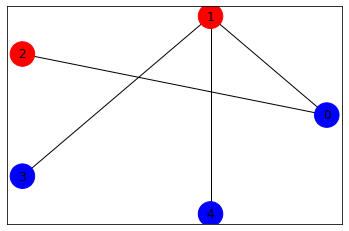

In [15]:
sol = max((v ** 2, k) for k, v in result.eigenstate.items())  # take the sample that appears most often
print(dict(enumerate(sol[1][::-1])))
draw_sol(G, sol[1], pos)

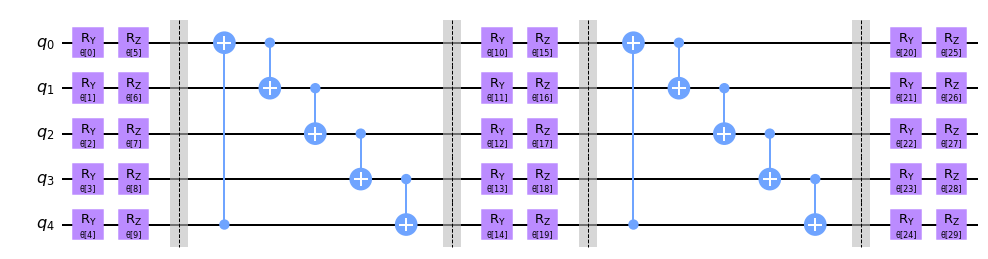

In [43]:
# More complicated variational form
ansatz = TwoLocal(H.num_qubits, ['ry', 'rz'], 'cx', entanglement='circular', reps=2, insert_barriers=True)
ansatz.draw(output='mpl')

In [44]:
algorithm_globals.random_seed = seed
vqe = VQE(optimizer=COBYLA(maxiter=maxiter), quantum_instance=ins, ansatz=ansatz)
result = vqe.compute_minimum_eigenvalue(H)
print(result)
print('ground state energy', result.optimal_value)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 200,
    'eigenstate': {   '00000': 0.044721359549995794,
                      '00001': 0.03162277660168379,
                      '00010': 0.10488088481701516,
                      '00100': 0.0670820393249937,
                      '00101': 0.1284523257866513,
                      '00110': 0.232379000772445,
                      '00111': 0.022360679774997897,
                      '01001': 0.2024845673131659,
                      '01010': 0.03162277660168379,
                      '01101': 0.1,
                      '01110': 0.03162277660168379,
                      '01111': 0.022360679774997897,
                      '10001': 0.16583123951776998,
                      '10010': 0.03162277660168379,
                      '10101': 0.10246950765959599,
                      '10110': 0.03162277660168379,
                      '10111': 0.03162277660168379,
                      '11001': 0.8988882021697693,
             

In [45]:
for bit, sqrt_prob in sorted(result.eigenstate.items()):
    print(f'cost {cost_function(bit, G)}, prob {sqrt_prob ** 2:.5f}, {dict(enumerate(bit[::-1]))}')

cost 0, prob 0.00200, {0: '0', 1: '0', 2: '0', 3: '0', 4: '0'}
cost 2, prob 0.00100, {0: '1', 1: '0', 2: '0', 3: '0', 4: '0'}
cost 3, prob 0.01100, {0: '0', 1: '1', 2: '0', 3: '0', 4: '0'}
cost 1, prob 0.00450, {0: '0', 1: '0', 2: '1', 3: '0', 4: '0'}
cost 1, prob 0.01650, {0: '1', 1: '0', 2: '1', 3: '0', 4: '0'}
cost 4, prob 0.05400, {0: '0', 1: '1', 2: '1', 3: '0', 4: '0'}
cost 2, prob 0.00050, {0: '1', 1: '1', 2: '1', 3: '0', 4: '0'}
cost 3, prob 0.04100, {0: '1', 1: '0', 2: '0', 3: '1', 4: '0'}
cost 2, prob 0.00100, {0: '0', 1: '1', 2: '0', 3: '1', 4: '0'}
cost 2, prob 0.01000, {0: '1', 1: '0', 2: '1', 3: '1', 4: '0'}
cost 3, prob 0.00100, {0: '0', 1: '1', 2: '1', 3: '1', 4: '0'}
cost 1, prob 0.00050, {0: '1', 1: '1', 2: '1', 3: '1', 4: '0'}
cost 3, prob 0.02750, {0: '1', 1: '0', 2: '0', 3: '0', 4: '1'}
cost 2, prob 0.00100, {0: '0', 1: '1', 2: '0', 3: '0', 4: '1'}
cost 2, prob 0.01050, {0: '1', 1: '0', 2: '1', 3: '0', 4: '1'}
cost 3, prob 0.00100, {0: '0', 1: '1', 2: '1', 3: '0', 

{0: '1', 1: '0', 2: '0', 3: '1', 4: '1'}
cost 4


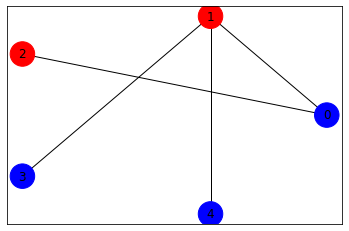

In [46]:
sol = max((v ** 2, k) for k, v in result.eigenstate.items())  # take the sample that appears most often
print(dict(enumerate(sol[1][::-1])))
draw_sol(G, sol[1], pos)

In [47]:
algorithm_globals.random_seed = seed
qaoa = QAOA(optimizer=COBYLA(maxiter=maxiter), quantum_instance=ins, reps=1)
result = qaoa.compute_minimum_eigenvalue(H)
print(result)
print('ground state energy', result.optimal_value)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 34,
    'eigenstate': {   '00000': 0.08944271909999159,
                      '00001': 0.07745966692414834,
                      '00010': 0.22803508501982758,
                      '00011': 0.3255764119219941,
                      '00100': 0.05916079783099616,
                      '00101': 0.05,
                      '00110': 0.37749172176353746,
                      '00111': 0.05916079783099616,
                      '01000': 0.03162277660168379,
                      '01001': 0.24596747752497686,
                      '01010': 0.1341640786499874,
                      '01011': 0.12041594578792296,
                      '01100': 0.1284523257866513,
                      '01101': 0.1284523257866513,
                      '01110': 0.22360679774997896,
                      '01111': 0.022360679774997897,
                      '10001': 0.21213203435596426,
                      '10010': 0.12649110640673517,
             

In [48]:
for bit, sqrt_prob in sorted(result.eigenstate.items()):
    print(f'cost {cost_function(bit, G)}, prob {sqrt_prob ** 2:.5f}, {dict(enumerate(bit[::-1]))}')

cost 0, prob 0.00800, {0: '0', 1: '0', 2: '0', 3: '0', 4: '0'}
cost 2, prob 0.00600, {0: '1', 1: '0', 2: '0', 3: '0', 4: '0'}
cost 3, prob 0.05200, {0: '0', 1: '1', 2: '0', 3: '0', 4: '0'}
cost 3, prob 0.10600, {0: '1', 1: '1', 2: '0', 3: '0', 4: '0'}
cost 1, prob 0.00350, {0: '0', 1: '0', 2: '1', 3: '0', 4: '0'}
cost 1, prob 0.00250, {0: '1', 1: '0', 2: '1', 3: '0', 4: '0'}
cost 4, prob 0.14250, {0: '0', 1: '1', 2: '1', 3: '0', 4: '0'}
cost 2, prob 0.00350, {0: '1', 1: '1', 2: '1', 3: '0', 4: '0'}
cost 1, prob 0.00100, {0: '0', 1: '0', 2: '0', 3: '1', 4: '0'}
cost 3, prob 0.06050, {0: '1', 1: '0', 2: '0', 3: '1', 4: '0'}
cost 2, prob 0.01800, {0: '0', 1: '1', 2: '0', 3: '1', 4: '0'}
cost 2, prob 0.01450, {0: '1', 1: '1', 2: '0', 3: '1', 4: '0'}
cost 2, prob 0.01650, {0: '0', 1: '0', 2: '1', 3: '1', 4: '0'}
cost 2, prob 0.01650, {0: '1', 1: '0', 2: '1', 3: '1', 4: '0'}
cost 3, prob 0.05000, {0: '0', 1: '1', 2: '1', 3: '1', 4: '0'}
cost 1, prob 0.00050, {0: '1', 1: '1', 2: '1', 3: '1', 

{0: '1', 1: '0', 2: '0', 3: '1', 4: '1'}
cost 4


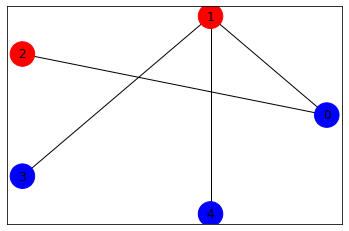

In [22]:
sol = max((v ** 2, k) for k, v in result.eigenstate.items())  # take the sample that appears most often
print(dict(enumerate(sol[1][::-1])))
draw_sol(G, sol[1], pos)

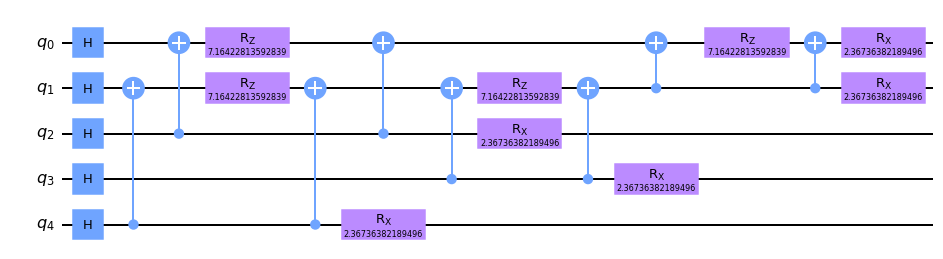

In [50]:
# Visualize the ansatz of QAOA
qaoa.get_optimal_circuit().draw(output='mpl')

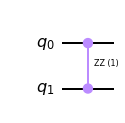

In [51]:
# RZZ gate
qc = QuantumCircuit(2)
qc.rzz(1, 0, 1)
qc.draw(output='mpl')

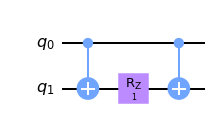

In [52]:
# RZZ gate converted into basis gates.
qc2 = transpile(qc, basis_gates=['rz', 'cx'])
qc2.draw(output='mpl')

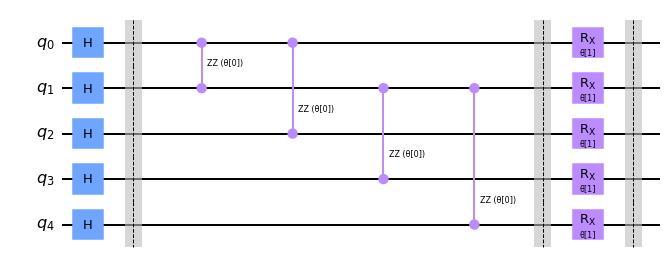

In [55]:
# Design QAOA ansatz by myself
# barriers are just for visualization

def qaoa_ansatz(G, p):
    n = len(G.nodes())
    m = len(G.edges())
    params = ParameterVector('θ', length=p*2)
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.barrier()
    for t in range(p):
        for i, j in G.edges():
            qc.rzz(params[2*t], j, i)
        qc.barrier()
        for i in G.nodes():
            qc.rx(params[2*t+1], i)
        qc.barrier()
    return qc

ansatz = qaoa_ansatz(G, 1)
ansatz.draw(output='mpl')

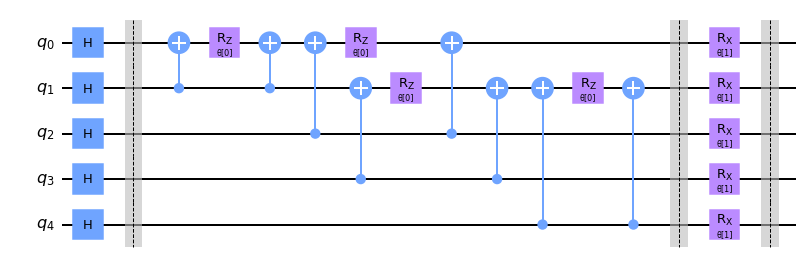

In [56]:
ansatz2 = transpile(ansatz, basis_gates=['rz', 'rx', 'cx', 'h'])
ansatz2.draw(output='mpl')

In [57]:
algorithm_globals.random_seed = seed
vqe = VQE(optimizer=COBYLA(maxiter=maxiter), quantum_instance=ins, ansatz=ansatz)
result = vqe.compute_minimum_eigenvalue(H)
print(result)
print('ground state energy', result.optimal_value)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 32,
    'eigenstate': {   '00000': 0.1,
                      '00001': 0.07745966692414834,
                      '00010': 0.22583179581272428,
                      '00011': 0.32787192621510003,
                      '00100': 0.09746794344808964,
                      '00101': 0.05477225575051661,
                      '00110': 0.38858718455450897,
                      '00111': 0.03162277660168379,
                      '01000': 0.022360679774997897,
                      '01001': 0.23874672772626646,
                      '01010': 0.12449899597988733,
                      '01011': 0.10723805294763608,
                      '01100': 0.1161895003862225,
                      '01101': 0.12449899597988733,
                      '01110': 0.2202271554554524,
                      '01111': 0.022360679774997897,
                      '10001': 0.20615528128088303,
                      '10010': 0.130384048104053,
             

In [58]:
for bit, sqrt_prob in sorted(result.eigenstate.items()):
    print(f'cost {cost_function(bit, G)}, prob {sqrt_prob ** 2:.5f}, {dict(enumerate(bit[::-1]))}')

cost 0, prob 0.01000, {0: '0', 1: '0', 2: '0', 3: '0', 4: '0'}
cost 2, prob 0.00600, {0: '1', 1: '0', 2: '0', 3: '0', 4: '0'}
cost 3, prob 0.05100, {0: '0', 1: '1', 2: '0', 3: '0', 4: '0'}
cost 3, prob 0.10750, {0: '1', 1: '1', 2: '0', 3: '0', 4: '0'}
cost 1, prob 0.00950, {0: '0', 1: '0', 2: '1', 3: '0', 4: '0'}
cost 1, prob 0.00300, {0: '1', 1: '0', 2: '1', 3: '0', 4: '0'}
cost 4, prob 0.15100, {0: '0', 1: '1', 2: '1', 3: '0', 4: '0'}
cost 2, prob 0.00100, {0: '1', 1: '1', 2: '1', 3: '0', 4: '0'}
cost 1, prob 0.00050, {0: '0', 1: '0', 2: '0', 3: '1', 4: '0'}
cost 3, prob 0.05700, {0: '1', 1: '0', 2: '0', 3: '1', 4: '0'}
cost 2, prob 0.01550, {0: '0', 1: '1', 2: '0', 3: '1', 4: '0'}
cost 2, prob 0.01150, {0: '1', 1: '1', 2: '0', 3: '1', 4: '0'}
cost 2, prob 0.01350, {0: '0', 1: '0', 2: '1', 3: '1', 4: '0'}
cost 2, prob 0.01550, {0: '1', 1: '0', 2: '1', 3: '1', 4: '0'}
cost 3, prob 0.04850, {0: '0', 1: '1', 2: '1', 3: '1', 4: '0'}
cost 1, prob 0.00050, {0: '1', 1: '1', 2: '1', 3: '1', 

{0: '1', 1: '0', 2: '0', 3: '1', 4: '1'}
cost 4


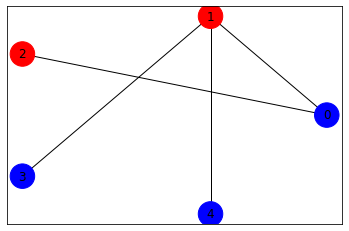

In [68]:
sol = max((v ** 2, k) for k, v in result.eigenstate.items())  # take the sample that appears most often
print(dict(enumerate(sol[1][::-1])))
draw_sol(G, sol[1], pos)

## Solve Maxcut with Qiskit-optimization

Note that I recommend to upgrade qiskit-optimization to fix some issues as follows

```
%pip uninstall qiskit-optimization
%pip install https://github.com/Qiskit/qiskit-optimization/archive/stable/0.1.zip
```

In [69]:
# Make an optimization problem with Docplex
# See http://ibmdecisionoptimization.github.io/docplex-doc/mp/index.html for details
from docplex.mp.model import Model

In [70]:
def model(G):
    mod = Model('maxcut')
    var = [mod.binary_var(name=f'x{i}') for i in range(len(G.nodes()))]
    mod.maximize(mod.sum(var[i] * (1-var[j]) + (1-var[i]) * var[j] for i, j in G.edges()))
    return mod
mod = model(G)
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: maxcut

Maximize
 obj: 2 x0 + 3 x1 + x2 + x3 + x4 + [ - 4 x0*x1 - 4 x0*x2 - 4 x1*x3 - 4 x1*x4 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End



In [86]:
# Solve the model with CPLEX
# You need to install cplex as follows.
# %pip install cplex
# If you didn't inst}all cplex, you can skip this cell.
print(mod.solve())

DOcplexException: Cannot solve model: no CPLEX runtime found.

In [73]:
# Convert the Docplex model into QuadraticProgram, then Hamiltonian.
qp = QuadraticProgram()
qp.from_docplex(mod)
H2, offset2 = qp.to_ising()
print('from qp')
print(H2)
print(offset2)
print('comparison with the previous Hamiltonian')
print((H - H2).reduce())
print(offset - offset2)

from qp
0.5 * ZIIZI
+ 0.5 * IZIZI
+ 0.5 * IIZIZ
+ 0.5 * IIIZZ
-2.0
comparison with the previous Hamiltonian
0.0 * IIIII
0.0


optimal function value: 4.0
optimal value: [1. 0. 0. 1. 1.]
status: SUCCESS
cost 4.0, prob 0.02388, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 1}
cost 4.0, prob 0.02328, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0}
cost 3.0, prob 0.01068, {'x0': 0, 'x1': 1, 'x2': 0, 'x3': 0, 'x4': 0}
cost 3.0, prob 0.01413, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 1}
cost 3.0, prob 0.01194, {'x0': 1, 'x1': 0, 'x2': 1, 'x3': 1, 'x4': 1}
cost 3.0, prob 0.01998, {'x0': 1, 'x1': 1, 'x2': 0, 'x3': 0, 'x4': 0}
cost 3.0, prob 0.01413, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 0}
cost 3.0, prob 0.03160, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 1}
cost 3.0, prob 0.03583, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 1, 'x4': 0}
cost 3.0, prob 0.01689, {'x0': 0, 'x1': 0, 'x2': 1, 'x3': 1, 'x4': 1}
cost 2.0, prob 0.00925, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 1, 'x4': 1}
cost 2.0, prob 0.01771, {'x0': 1, 'x1': 0, 'x2': 1, 'x3': 0, 'x4': 1}
cost 2.0, prob 0.06777, {'x0': 1, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0}
cost 2.0, prob

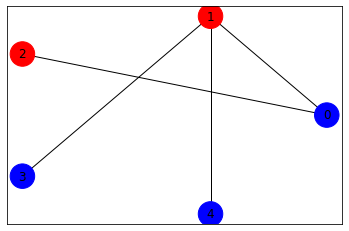

In [80]:
# Solve the problem with qiskit-optimization's MinimumEigenOptimizer
qp = QuadraticProgram()
qp.from_docplex(mod)
maxiter2 = 1000
qaoa = QAOA(optimizer=COBYLA(maxiter=maxiter2), quantum_instance=ins, reps=3)
min_eigen_optimizer = MinimumEigenOptimizer(qaoa)
result = min_eigen_optimizer.solve(qp)
print(result)
varnames = [v.name for v in result.variables]
for sample in result.samples:
    x = [int(x) for x in sample.x]
    print(f'cost {sample.fval}, prob {sample.probability:.5f}, {dict(zip(varnames, x))}')
draw_sol(G, [int(x) for x in result.x], pos)  # need to convert float to int

## Solve Maxcut with noise model

In [81]:
# Use noise model
from qiskit import IBMQ
from qiskit.providers.aer.noise import NoiseModel

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_belem')
noise_model = NoiseModel.from_backend(backend)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['reset', 'id', 'sx', 'measure', 'x', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [4, 3]), ('cx', [3, 4]), ('cx', [3, 1]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [1, 2]), ('cx', [1, 0]), ('cx', [0, 1]), ('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


optimal function value: 4.0
optimal value: [0. 1. 1. 0. 0.]
status: SUCCESS
cost 4.0, prob 0.02517, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0}
cost 4.0, prob 0.02990, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 1}
cost 3.0, prob 0.03172, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 1}
cost 3.0, prob 0.02364, {'x0': 0, 'x1': 1, 'x2': 0, 'x3': 0, 'x4': 0}
cost 3.0, prob 0.03230, {'x0': 0, 'x1': 0, 'x2': 1, 'x3': 1, 'x4': 1}
cost 3.0, prob 0.01221, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 1}
cost 3.0, prob 0.01365, {'x0': 1, 'x1': 0, 'x2': 1, 'x3': 1, 'x4': 1}
cost 3.0, prob 0.03287, {'x0': 1, 'x1': 1, 'x2': 0, 'x3': 0, 'x4': 0}
cost 3.0, prob 0.01615, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 0}
cost 3.0, prob 0.03611, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 1, 'x4': 0}
cost 2.0, prob 0.01495, {'x0': 0, 'x1': 1, 'x2': 0, 'x3': 1, 'x4': 0}
cost 2.0, prob 0.02590, {'x0': 1, 'x1': 1, 'x2': 0, 'x3': 1, 'x4': 0}
cost 2.0, prob 0.01727, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 1, 'x4': 1}
cost 2.0, prob

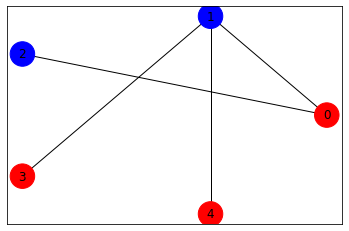

In [82]:
# QAOA with reps=5 and ibmq_belem noise simulator
algorithm_globals.random_seed = seed
ins_noise = QuantumInstance(backend=Aer.get_backend('aer_simulator'), seed_simulator=seed, seed_transpiler=seed, noise_model=noise_model)
qaoa = QAOA(optimizer=COBYLA(maxiter=maxiter2), quantum_instance=ins_noise, reps=5)
min_eigen_optimizer = MinimumEigenOptimizer(qaoa)
result = min_eigen_optimizer.solve(qp)
print(result)
varnames = [v.name for v in result.variables]
for sample in result.samples:
    x = [int(x) for x in sample.x]
    print(f'cost {sample.fval}, prob {sample.probability:.5f}, {dict(zip(varnames, x))}')
draw_sol(G, [int(x) for x in result.x], pos)  # need to convert float to int

In [38]:
# Custom noise model
# See https://qiskit.org/documentation/apidoc/aer_noise.html for details
import qiskit.providers.aer.noise as noise

# Error probabilities
prob_1 = 0.01  # 1-qubit gate
prob_2 = 0.1   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model2 = noise.NoiseModel()
noise_model2.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model2.add_all_qubit_quantum_error(error_2, ['cx'])

optimal function value: 4.0
optimal value: [0. 1. 1. 0. 0.]
status: SUCCESS
cost 4.0, prob 0.04785, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0}
cost 4.0, prob 0.04590, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 1}
cost 3.0, prob 0.03320, {'x0': 0, 'x1': 1, 'x2': 0, 'x3': 0, 'x4': 0}
cost 3.0, prob 0.03125, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 1}
cost 3.0, prob 0.03711, {'x0': 0, 'x1': 0, 'x2': 1, 'x3': 1, 'x4': 1}
cost 3.0, prob 0.03223, {'x0': 1, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 0}
cost 3.0, prob 0.02637, {'x0': 1, 'x1': 0, 'x2': 1, 'x3': 1, 'x4': 1}
cost 3.0, prob 0.02930, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 1}
cost 3.0, prob 0.02539, {'x0': 0, 'x1': 1, 'x2': 1, 'x3': 1, 'x4': 0}
cost 3.0, prob 0.05078, {'x0': 1, 'x1': 1, 'x2': 0, 'x3': 0, 'x4': 0}
cost 2.0, prob 0.03711, {'x0': 0, 'x1': 0, 'x2': 0, 'x3': 1, 'x4': 1}
cost 2.0, prob 0.01855, {'x0': 1, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0}
cost 2.0, prob 0.03711, {'x0': 0, 'x1': 0, 'x2': 1, 'x3': 0, 'x4': 1}
cost 2.0, prob

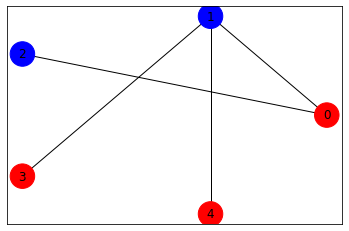

In [39]:
# QAOA with p=5 and custom noise simulator
algorithm_globals.random_seed = seed
ins_noise2 =  quantum_instance=QuantumInstance(backend=Aer.get_backend('aer_simulator'), seed_simulator=seed, noise_model=noise_model2)
qaoa = QAOA(optimizer=COBYLA(maxiter=maxiter2), quantum_instance=ins_noise2, reps=5)
min_eigen_optimizer = MinimumEigenOptimizer(qaoa)
result = min_eigen_optimizer.solve(qp)
print(result)
varnames = [v.name for v in result.variables]
for sample in result.samples:
    x = [int(x) for x in sample.x]
    print(f'cost {sample.fval}, prob {sample.probability:.5f}, {dict(zip(varnames, x))}')
draw_sol(G, [int(x) for x in result.x], pos)  # need to convert float to int